# Трудности при обучении глубоких нейронных сетей

Код для визуализации результатов обучения моделей:

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # Dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. Plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. Plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. Add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. Calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. Plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. Add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

Загрузим данные, создадим сеть, обучим ее и посмотрим на практике, как проходит обучение.

Загрузим **датасет MNIST**:

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# Transforms for data
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.13], [0.3]),
    ]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


Создадим сеть с **сигмоидой** в качестве функции активации:

In [ ]:
import torch.nn as nn


class SimpleMNIST_NN(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid):
        super().__init__()
        self.n_layers = n_layers  # num of layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]  # input layer
        for _ in range(n_layers - 1):  # append num of layers
            layers.append(nn.Linear(100, 100))
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))  # 10 classes
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # reshape to [-1, 784]
        x = self.layers(x)
        return x

Реализуем пайплайн обучения модели на Lightning.


In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs “manually”
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from Pytorch Lightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # Aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # Aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

Создадим и запустим обучение модели с **двумя скрытыми слоями** и одним выходным слоем:

In [ ]:
model_name = "n_layers2_sigmoid"
model = SimpleMNIST_NN(n_layers=2)

print(model)

SimpleMNIST_NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger


trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(
    model=pipeline,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 89.6 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
89.6 K    Trainable params
0         Non-trainable params
89.6 K    Total params
0.358     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


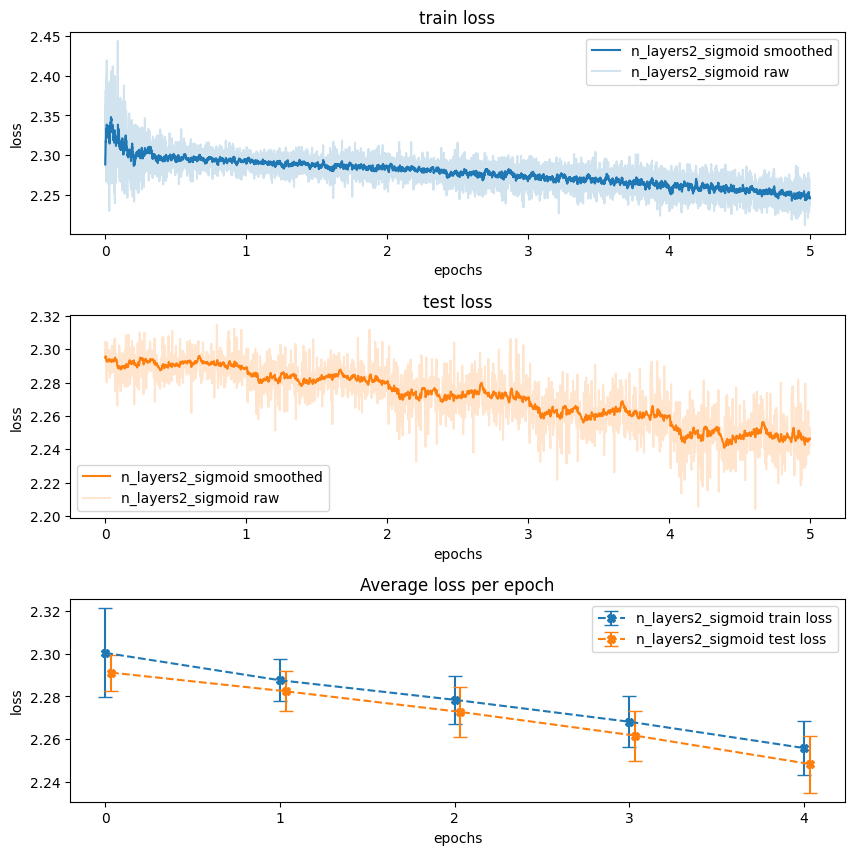

In [ ]:
history_plotter.plot([model_name])

А теперь посмотрим на модель **с тремя скрытыми слоями** и одним выходным слоем:

In [ ]:
model_name = "n_layers3_sigmoid"
model = SimpleMNIST_NN(n_layers=3)
print(model)

SimpleMNIST_NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [ ]:
trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


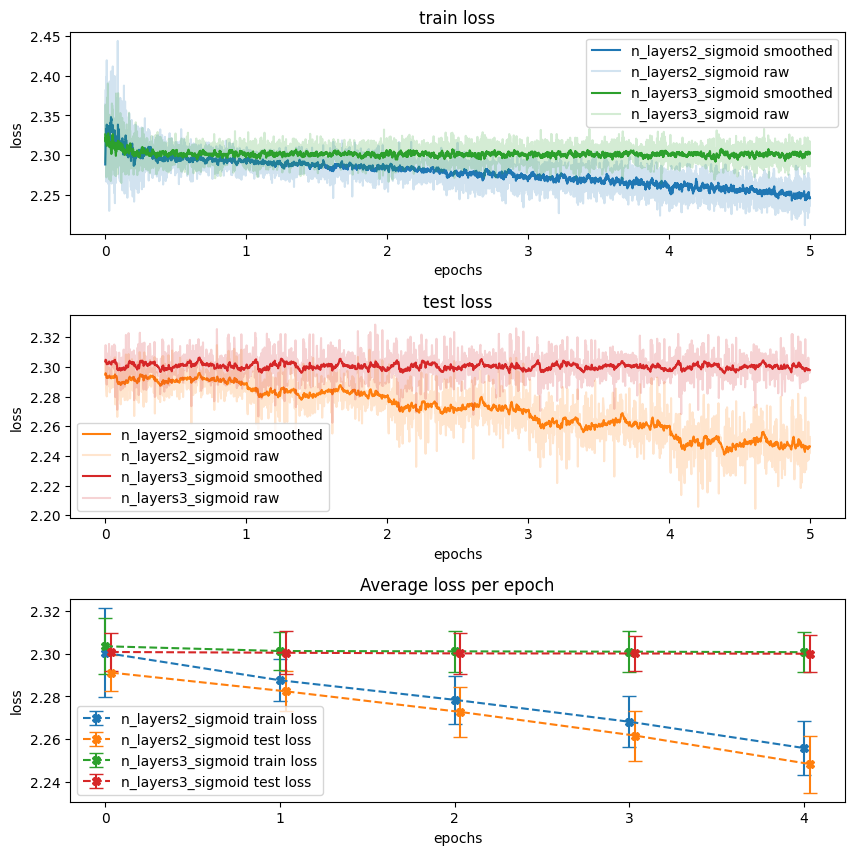

In [ ]:
history_plotter.plot(["n_layers2_sigmoid", model_name])

Нейросеть с тремя слоями вообще **не учится**. Почему? Попробуем разобраться.

Для этого напишем функции, которые будут следить за **распределением градиентов** и **активаций** на наших слоях.

Воспользуемся методами `register_forward_hook` и `register_backward_hook` из библиотеки PyTorch для того, чтобы выполнять эти функции при запуске прямого или обратного распространения через нашу сеть.

**Замечание:** *На самом деле, если увеличить learning rate, размер батча или число нейронов, то нейросеть начнет учиться. Это учебный пример, чтобы показать, что такое бывает.*

*Комментарий к коду:*

В коде ниже используются [замыкания (closure) ✏️[blog]](https://habr.com/ru/articles/781866/). Это функции, определяющие и возвращающие другие функции. Они нужны, чтобы передавать в [пространство имен ✏️[blog]](https://realpython.com/python-namespaces-scope/) вложенной функции дополнительные переменные. Функции `get_forward_hook` и `get_backward_hook` — это замыкания.

Зачем такие сложности? Дело в том, что регистрируемые в `child.register_forward_hook` и `child.weight.register_hook` функции должны иметь фиксированное количество переменных на входе: для `forward_hook` — `(self, input_, output)` (названия, кроме `self`, могут варьироваться), для `backward_hook` — `(grad)` (название может варьироваться).

Мы хотим сохранить значения карт признаков и градиентов. Для хранения значений мы используем словарь листов `defaultdict(list)`, который определяем в функции  `register_model_hooks` в переменную `history_dict`. Словарь в Python является [изменяемым (mutable) ✏️[blog]](https://realpython.com/python-mutable-vs-immutable-types/#:~:text=Python%20has%20both%20mutable%20and,dictionaries%2C%20and%20sets%20are%20mutable.) объектом. Мы передаем в функции  `get_forward_hook` и `get_backward_hook` ссылку на словарь, куда нужно записывать интересные нам данные, и ключ для словаря. Так мы извлекаем значения из сети.



In [ ]:
from collections import defaultdict


def get_forward_hook(history_dict, key):
    def forward_hook(self, input_, output):
        history_dict[key] = input_[0].cpu().detach().numpy().flatten()

    return forward_hook


def get_backward_hook(history_dict, key):
    def backward_hook(grad):  # for tensors
        history_dict[key] = grad.abs().cpu().detach().numpy().flatten()

    return backward_hook


def register_model_hooks(model):
    cur_ind = 0
    history_dict = defaultdict(list)
    for child in model.layers.children():
        if isinstance(child, nn.Linear):
            forward_hook = get_forward_hook(history_dict, key=f"sigmoid_out_{cur_ind}")
            child.register_forward_hook(forward_hook)

            cur_ind += 1
            backward_hook = get_backward_hook(
                history_dict, key=f"gradient_linear_{cur_ind}"
            )
            child.weight.register_hook(backward_hook)
    return history_dict

Запустим обучение **модели с тремя слоями**:

In [ ]:
model_name = "n_layers3_sigmoid2"
model = SimpleMNIST_NN(n_layers=3)

hooks_data_history = register_model_hooks(model)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


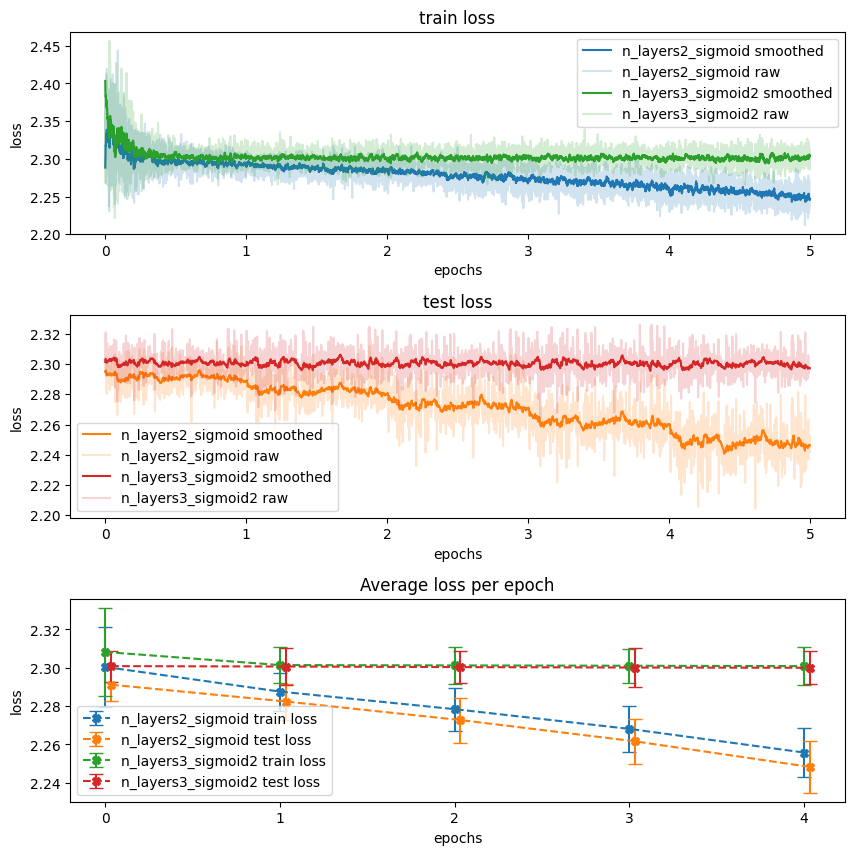

In [ ]:
history_plotter.plot(["n_layers2_sigmoid", model_name])

In [ ]:
def plot_hooks_data(hooks_data_history):
    keys = hooks_data_history.keys()
    n_layers = len(keys) // 2

    activation_names = [f"sigmoid_out_{i}" for i in range(1, n_layers)]
    activations_on_layers = [
        hooks_data_history[activation] for activation in activation_names
    ]

    gradient_names = [f"gradient_linear_{i + 1}" for i in range(n_layers)]
    gradients_on_layers = [hooks_data_history[gradient] for gradient in gradient_names]

    for plot_name, values, labels in zip(
        ["activations", "gradients"],
        [activations_on_layers, gradients_on_layers],
        [activation_names, gradient_names],
    ):
        fig, ax = plt.subplots(1, len(labels), figsize=(14, 4), sharey="row")
        for label_idx, label in enumerate(labels):
            ax[label_idx].boxplot(values[label_idx], labels=[label])
        plt.show()

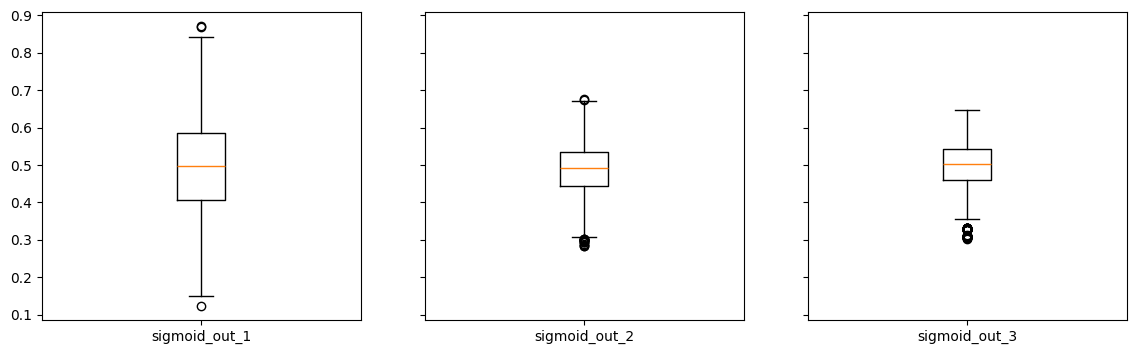

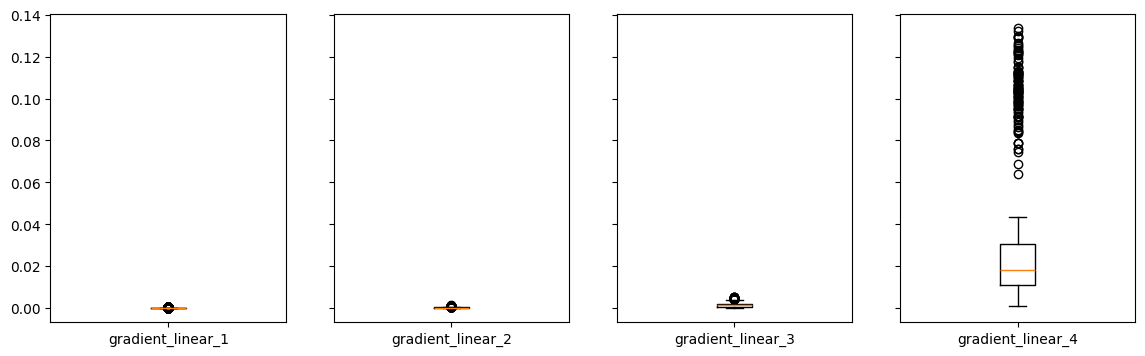

In [ ]:
plot_hooks_data(hooks_data_history)

Мы видим, что градиент модели стремительно затухает. Первые слои, до которых градиент доходит последним, получают значения градиента, мало отличимые от нуля.



# Затухание градиента



Посмотрим на обычную сигмоиду:

$$\sigma(z) = \dfrac 1 {1 + e^{-z}}$$

Ее производная, как мы уже выводили, равна:

$$\dfrac {\partial \sigma(z)} {\partial z} = \sigma(z) (1 - \sigma(z))$$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/activation_function_sigmoid.png" width="1000"></center>

Какое максимальное значение у такой функции?

Сигмоида находится в пределах от $0$ до $1$. **Максимальное значение производной** сигмоиды  $=\dfrac 1 4$.

Теперь возьмем нейронную сеть из 5 слоев:


<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/simple_nn_with_sigmoid.png" width="750">

Посчитаем у нее градиент:

$$\dfrac {\partial L} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial y} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_5z)} {\partial z} w_5 \le \dfrac 1 4 \dfrac {\partial L} {\partial y}  w_5 $$

Аналогично можно посчитать градиент для $z_3$:

$$\dfrac {\partial L} {\partial z_3} = \dfrac {\partial L} {\partial z_4} \dfrac {\partial z_4} {\partial z_3} \le \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_4z)} {\partial z} w_5 \le \left({\dfrac 1 4}\right)^2 \dfrac {\partial L} {\partial y}  w_5 w_4$$

И так далее:

$$\dfrac {\partial L} {\partial x}  \le \left({\dfrac 1 4}\right)^5 \dfrac {\partial L} {\partial y}  w_5 w_4 w_3 w_2 w_1$$

Таким образом, при **маленьких весах** градиент начинает **экспоненциально затухать**.

При **больших весах**, из-за chain-rule, может происходить **взрыв градиента**. Взрыву градиента особенно подвержены рекуррентные нейронные сети, о которых будет рассказано позже (в них сигналы пропускаются через один и тот же блок с одними и теми же весами), а также сети с использованием SoftMax (это происходит в архитектурах трансформеров).

Для некоторых функций активации картина будет не столь катастрофична, но тоже неприятна.
При выполнении заданий вы посмотрите, например, как ведет себя функция **ReLU** в этом случае.

Давайте подумаем, что можно сделать с нейронной сетью, чтобы она начала учиться. В начале рассмотрим методы, **не изменяющие структуру сети** (без добавления дополнительных слоев), также зафиксируем количество нейронов и параметры оптимизатора.


# Нормализация входов и выходов

Начнем с уже знакомого: **нормализация**.

## Нормализация входных данных

Представим себе, что данные, которые мы подаем в нейросеть, распределены следующим образом:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/data_before_normalization.png" width="400"></center>

Фактически нейросети работают со скалярными произведениями. В этом плане два вектора, изображенные на рисунке, **не сильно отличаются**. Также и точки нашего датасета слабо разделимы. Чтобы с этим работать, нейросеть сначала должна подобрать **удобное преобразование**, а затем сравнивать объекты. Понятно, что это усложняет задачу.

Для того, чтобы облегчить нейросети задачу, входные признаки часто **нормируют**:

$$x1' = \dfrac {x1 - \mu_{x1}} {\sigma_{x1}}$$

$$x2' = \dfrac {x2 - \mu_{x2}} {\sigma_{x2}}$$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/data_after_normalization.png" width="450"></center>


 Такое преобразование действительно помогает нейросети:

$$ \large J(w,b) = \frac1m \sum L(\hat{y^i}, y^i)$$

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/normalization_helps_find_minimum_of_function.png" width="700"></center>

<center><em>Нормализация позволяет искать минимум целевой функции удобнее и быстрее</em></center>


## Нормализация целевых значений в задаче регрессии

В ряде приложений также нужна **нормализация выходных значений**, например, в задаче **регрессии**. Существует несколько причин, почему это необходимо.

### Взрыв градиента

В большинстве случаев мы **нормализуем входные данные**, чтобы среднее значение было равно $0$.

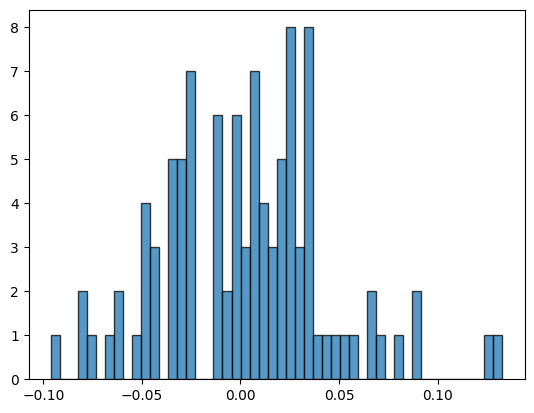

X mean: 0.00 X variance: 0.99


In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.randn((512, 100))  # Fake normalized data
plt.hist(x.mean(dim=0), bins=50, alpha=0.75, edgecolor="black")
plt.show()
print(f"X mean: {x.mean().item():.2f} X variance: {x.var().item():.2f}")

Кроме этого мы определенным **случайным** образом инициализируем веса.

In [ ]:
from torch import nn

net = nn.Sequential(
    nn.Linear(100, 50),  # weights randomly sampled from some random distribution
    nn.Sigmoid(),
    nn.Linear(50, 1),
)

Веса **нормально распределены вокруг нуля**:




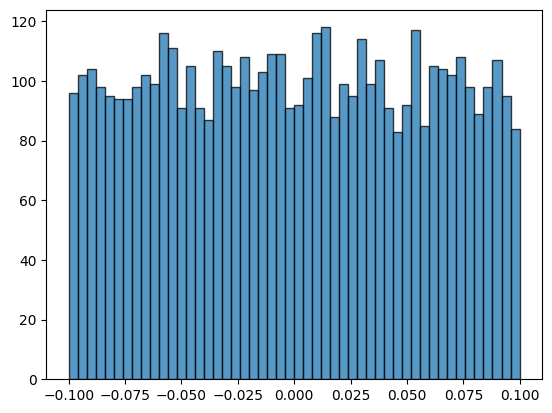

Weights mean: -0.00,  Weights variance: 0.00


In [ ]:
weights = net[0].weight.data.numpy()
plt.hist(weights.flatten(), bins=50, alpha=0.75, edgecolor="black")
plt.show()

print(f"Weights mean: {weights.mean():.2f},  Weights variance: {weights.var():.2f}")

Необученная сеть будет чаще всего предсказывать значения порядка $10^{-1}$.

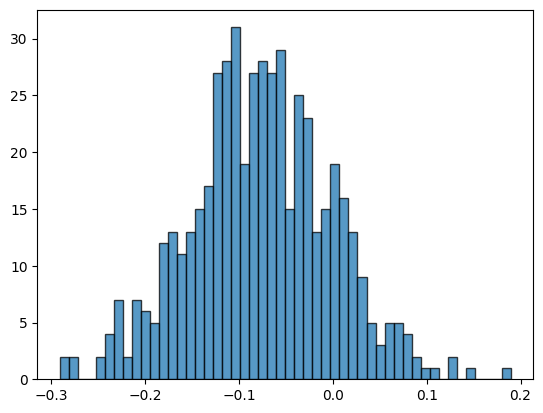

Out mean: -0.08, Out variance: 0.01


In [ ]:
out = net(x)
plt.hist(out.detach().numpy(), bins=50, alpha=0.75, edgecolor="black")
plt.show()

print(f"Out mean: {out.mean().item():.2f}, Out variance: {out.var().item():.2f}")

Предположим, мы предсказываем какую-то большую величину. Например, [стоимость дома в штате Калифорния в долларах 🛠️[doc]](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) (в датасете в Sklearn целевое значение нормировано на $100\ 000\$$). Стоимость лежит в диапазоне от $15\ 000\$$ до $500\ 000\$$.

Выберем случайные значения в этом диапазоне.

In [ ]:
# fake cost
targets = torch.randint(15_000, 500_000, (512, 1), dtype=torch.float32)
print(f"Target example: {targets[:10].flatten()}")

Target example: tensor([ 94967., 457708., 352809., 150987.,  80811., 122480., 399874., 255717.,
        257287., 487099.])


Если мы будем пытаться предсказывать эти значения, мы получим **очень большую ошибку**.

In [ ]:
criterion = nn.MSELoss()
loss = criterion(out, targets)
loss.backward()

print(f"Loss: {loss.item():.2f}")

Loss: 87905878016.00


Эта ошибка приведет к **большим значениям градиента** (cмотрим на значения по оси абсцисс), **большим значениям весов** и **нестабильному обучению**. На графике видно, что 2 слой сети получит большие значения градиентов и соотвественно сильно изменит значения весов.

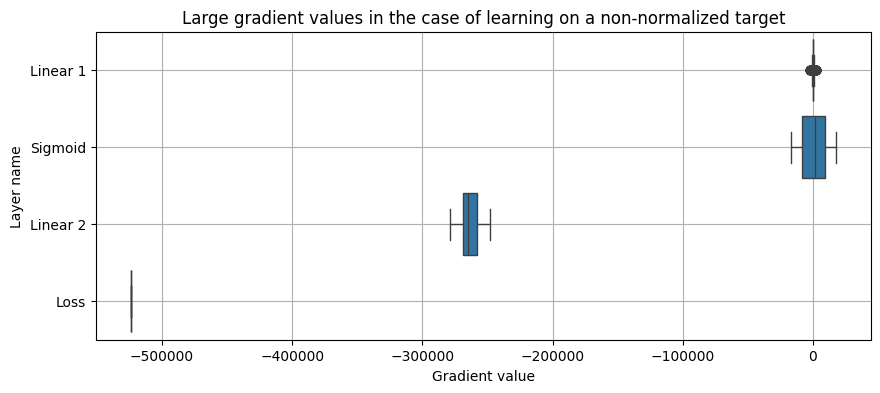

In [ ]:
import pandas as pd
import seaborn as sns

layer_names = ("Linear 1", "Sigmoid", "Linear 2", "Loss")
gradient_values = {}
for layer_name, p in zip(layer_names, net.parameters()):
    gradient_values[layer_name] = pd.Series(p.grad.detach().flatten().numpy())

gradient_values = pd.DataFrame(gradient_values)
data_to_plot = gradient_values.melt(value_name="Gradient value", var_name="Layer name")

plt.figure(figsize=(10, 4))
sns.boxplot(data=data_to_plot, x="Gradient value", y="Layer name")
plt.grid()
plt.title(f"Large gradient values in the case of learning on a non-normalized target")
plt.show()

Если мы **стандартизуем целевые значения**:

In [ ]:
mean = targets.float().mean()
std = targets.float().std()

transformed_targets = (targets - mean) / std
print(transformed_targets.flatten()[:10])

tensor([-1.1994,  1.4073,  0.6535, -0.7968, -1.3011, -1.0017,  0.9917, -0.0442,
        -0.0330,  1.6185])


То получим ошибку на 10 порядков **меньше**:

In [ ]:
net.zero_grad()
out = net(x)
loss = criterion(out, transformed_targets)
loss.backward()

print(f"Loss: {loss.item():.2f}")

Loss: 1.02


И **небольшие градиенты** (cмотрим на значения по оси абcцисс):


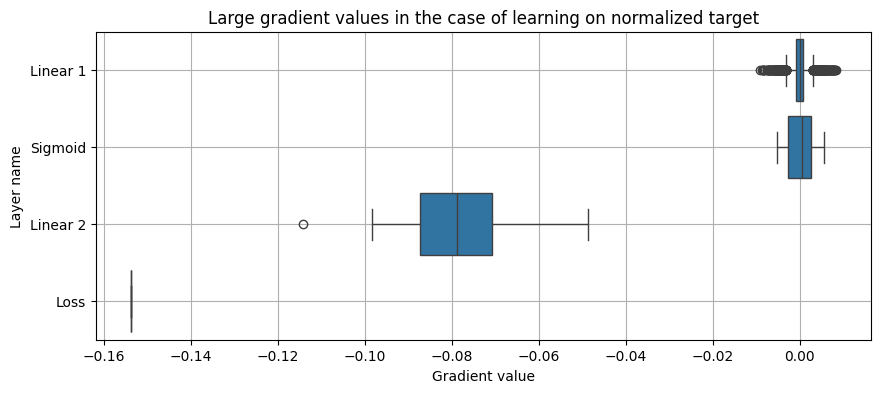

In [ ]:
layer_names = ("Linear 1", "Sigmoid", "Linear 2", "Loss")
gradient_values = {}
for layer_name, p in zip(layer_names, net.parameters()):
    gradient_values[layer_name] = pd.Series(p.grad.detach().flatten().numpy())

gradient_values = pd.DataFrame(gradient_values)
data_to_plot = gradient_values.melt(value_name="Gradient value", var_name="Layer name")

plt.figure(figsize=(10, 4))
sns.boxplot(data=data_to_plot, x="Gradient value", y="Layer name")
plt.grid()
plt.title(f"Large gradient values in the case of learning on normalized target")
plt.show()

### Multi-Dimensional регрессия

В ряде задач, например, при [**использовании нейронных сетей для моделирования физических процессов** 🎓[arxiv]](https://arxiv.org/abs/2007.13875), в задаче регрессии, необходимо вычислять **несколько целевых значений**. При этом необходимо помнить, что в качестве функционала ошибки в задачах регрессии часто выбирается **метрика расстояния**, а физические величины могут иметь **различный порядок** и **диапазон значений**.

Не самая лучшая идея — считать расстояние, когда по одной оси отложены нанометры, а по другой — килограммы.


В физических задачах полезно изучить, какие нормировки используют в **численных методах** для получения [безразмерных (**dimensionless**) величин 📚[book]](https://www.physics.umd.edu/perg/MathPhys/content/2/pstruc/dimsDE.htm). Это может подсказать хорошую, физически обоснованную нормировку.


# Инициализация весов

Одним из способов борьбы с затухающим градиентом является правильная **инициализация весов**. Как это сделать?

**Идея 1:** инициализировать все веса константой.

Проблема: градиент по всем весам будет одинаков, как и обновление весов. Все нейроны в слое будут учить одно и то же, или, в случае $\text{const} = 0$ и активации $\text{ReLU}$, [не будут учиться вообще ✏️[blog]](https://habr.com/ru/post/592711/).

**Вывод:** в качестве начальных весов нужно выбирать различные значения.

**Идея 2:** инициализировать веса нормальным (Гауссовским) шумом с матожиданием $0$ и маленькой дисперсией.

Маленькая дисперсия нужна, чтобы не получить огромные градиенты за большие изначальные ошибки в предсказании.

**Проблема:** инициализация нормальным шумом не гарантирует отсутствие взрыва или затухания градиента.

Рассмотрим на примере:

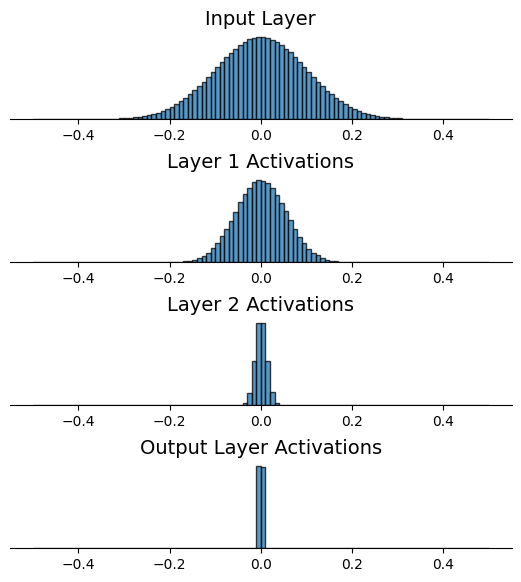

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_act(ax, x, layer_name):
    ax.hist(x.flatten(), bins=100, range=(-0.5, 0.5), alpha=0.75, edgecolor="black")
    ax.set_title(f"{layer_name}", fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', left=False, labelleft=False)

class NeuralNet:
    def __init__(self):
        np.random.seed(42)
        self.W1 = np.random.randn(3072, 500) * 0.01
        self.W2 = np.random.randn(500, 100) * 0.01
        self.W3 = np.random.randn(100, 10) * 0.01

    def predict(self, x):
        fig, axs = plt.subplots(4, 1, figsize=(6, 6))
        fig.tight_layout(pad=2)

        show_act(axs[0], x, "Input Layer")

        scores1 = x.dot(self.W1)
        activations1 = np.tanh(scores1)
        show_act(axs[1], activations1, "Layer 1 Activations")

        scores2 = activations1.dot(self.W2)
        activations2 = np.tanh(scores2)
        show_act(axs[2], activations2, "Layer 2 Activations")

        scores3 = activations2.dot(self.W3)
        show_act(axs[3], scores3, "Output Layer Activations")

        return scores3

x = np.random.randn(1000, 3072) * 0.1

simple_net = NeuralNet()
scores = simple_net.predict(x)


**Идея 3:** формализуем условия, при которых взрыв и затухание градиентов не будут происходить.

1. Нам бы хотелось, чтобы **дисперсии признаков**, получаемых на каждом слое, были одинаковы (т.е мы хотим задать начальные веса таким образом, чтобы входные признаки каждого линейного слоя были **одинаково нормализованы**).

Это важно, т.к. значения признаков используются при расчете градиента. Например, для линейного слоя:

$$y = wx+b$$
$$\dfrac{\partial y} {\partial w} = x$$

Запишем это условие:

$$Dz^i = Dz^j \tag{1}$$

2. Нам бы хотелось, чтобы **дисперсии градиентов** для разных слоев были одинаковы:

$$D\dfrac {\partial L} {\partial z^i} = D\dfrac {\partial L} {\partial z^j} \tag{2}$$


При выполнении этих условий градиент **не затухает** и **не взрывается**.

Инициализации Ксавье и Каймин Хе выводятся из этих условий.

## Инициализация Ксавье (Xavier Glorot)

Инициализация Ксавье была предложена в статье [Understanding the difficulty of training deep feedforward neural networks (Xavier et al., 2010) 🎓[article]](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Она используется для симметричных функций активации (**Sigmoid**, **Tanh**).

При инициализации весов [равномерным распределением 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BF%D1%80%D0%B5%D1%80%D1%8B%D0%B2%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B2%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) условия (1) и (2) преобразуются в:

 $$W_i \sim U[-\sqrt{\dfrac {6} {n_i + n_{i + 1}}}, \sqrt{\dfrac {6} {n_i + n_{i + 1}}}],$$

где $n_i$ — размерность выхода $i$-го слоя.

При инициализации весов [нормальным распределением 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) условия (1) и (2) преобразуются в:

$$W_i \sim N (0,  \text{std}=\sqrt{\dfrac{2}{n_i + n_{i + 1}}})$$

Можно использовать любое распределение.

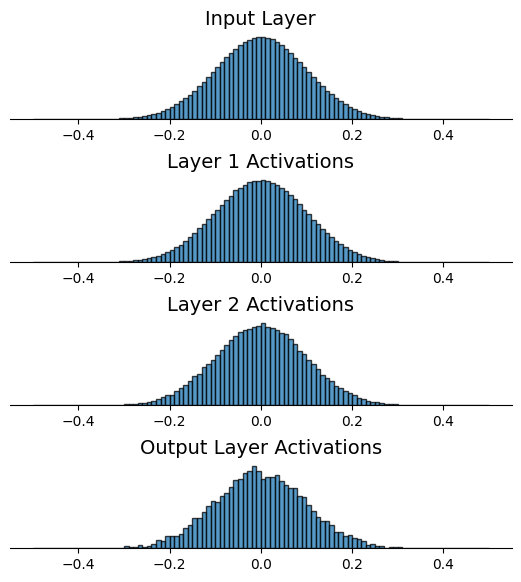

In [ ]:
class NeuralNet_Xavier(NeuralNet):
    def __init__(self):
        np.random.seed(42)
        self.W1 = np.random.randn(3072, 500) * np.sqrt(1 / 3072)
        self.W2 = np.random.randn(500, 100) * np.sqrt(1 / 500)
        self.W3 = np.random.randn(100, 10) * np.sqrt(1 / 100)

x = np.random.randn(1000, 3072) * 0.1

simple_net = NeuralNet_Xavier()
scores = simple_net.predict(x)


## Инициализация Каймин Хе (Kaiming He)

Инициализация Каймин Хе была предложена в статье
[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015) 🎓 [arxiv]](https://arxiv.org/pdf/1502.01852v1.pdf). Она используется для функции активации **ReLU** и ее модификаций (**PReLU**, **Leaky ReLU** и т.д.).

При инициализации весов нормальным распределением условия (1) и (2) преобразуются в:

$$W_i \sim N(0, \text{std}=\sqrt{\frac 2 {n_i}})$$

Для равномерного распределения:
$$W_i \sim U(-\sqrt{\frac 3 {n_i}}, \sqrt{\frac 3 {n_i}})$$



Подробный вывод формул:

[[colab] 🥨 Инициализация весов](https://colab.research.google.com/drive/1RzBp0oBmX5HoiptrsGHQ9qKB1GFFfx44)

## Важность инициализации весов

Инициализация весов существенно влияла на возможность обучения до появления слоев нормализации, о которых вы узнаете далее. При наличии слоев нормализации она лишь немного ускоряет сходимость в начале обучения.

Посмотрим на результаты из статьи [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015) 🎓[arxiv]](https://arxiv.org/pdf/1502.01852v1.pdf) (они получены **без слоев нормализации**).

1. Нейросеть может **сойтись значительно быстрее**. Графики для активации **ReLU**:


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/weight_initialization_influence_convergence_neural_networks.png" width="600"></center>

<center><em>Обучение нейронной сети с 22 слоями при использовании инициализации Kaiming He и Xavier</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1502.01852v1.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a></em></center>



2. В зависимости от выбранной активации сеть вообще может **сойтись или не сойтись**. Графики для активации **ReLU**:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/activation_function_influence_convergence_neural_networks.png" width="600"></center>

<center><em>Обучение нейронной сети с 30 слоями при использовании инициализации He и Xavier</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1502.01852v1.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a></em></center>

## Инициализация весов в PyTorch

Для инициализации весов в PyTorch используется модуль `torch.nn.init`, в котором для этого определены разные функции.

Нюанс состоит в том, что обычно для слоев разного типа может требоваться разная инициализация. Поэтому в функции, которая инициализирует слои вашей нейронной сети, желательно прописывать разное поведение для разных слоев.

Попробуем, например, добавить в нашу нейросеть инициализацию. Нам нужна инициализация Xavier, так как у нас `nn.Sigmoid`.

Метод `torch.nn.init.calculate_gain` возвращает рекомендуемое значение коэффициента масштабирования для стандартного отклонения заданной функции активации. Не забывайте его использовать для `torch.nn.init.xavier_normal_`.

Напишем функцию `init_weights` (ее тоже можно обернуть в замыкание, чтобы случайно не поменять `init_gain`) и применим ее к нашей модели с помощью `nn.Module.apply` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply), применяющему функцию ко всем подмодулям модели.

In [ ]:
activation_type = "sigmoid"
init_gain = torch.nn.init.calculate_gain(activation_type)


def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.xavier_normal_(m.weight, gain=init_gain)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

Запустим обучение модели с инициализацией весов Xavier:

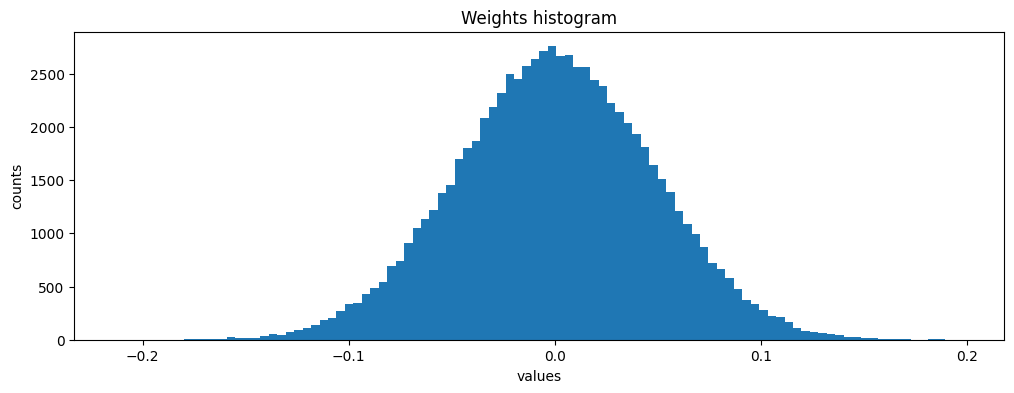

In [ ]:
model_name = "n3_layers_sigmoid_havier"
model = SimpleMNIST_NN(n_layers=3)
model.apply(init_weights)

# Plotting weights values of first (input) layer
plt.figure(figsize=(12, 4))
plt.hist(
    list(model.layers.children())[0].weight.cpu().detach().numpy().reshape(-1), bins=100
)
plt.title("Weights histogram")
plt.xlabel("values")
plt.ylabel("counts")
plt.show()

In [ ]:
trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


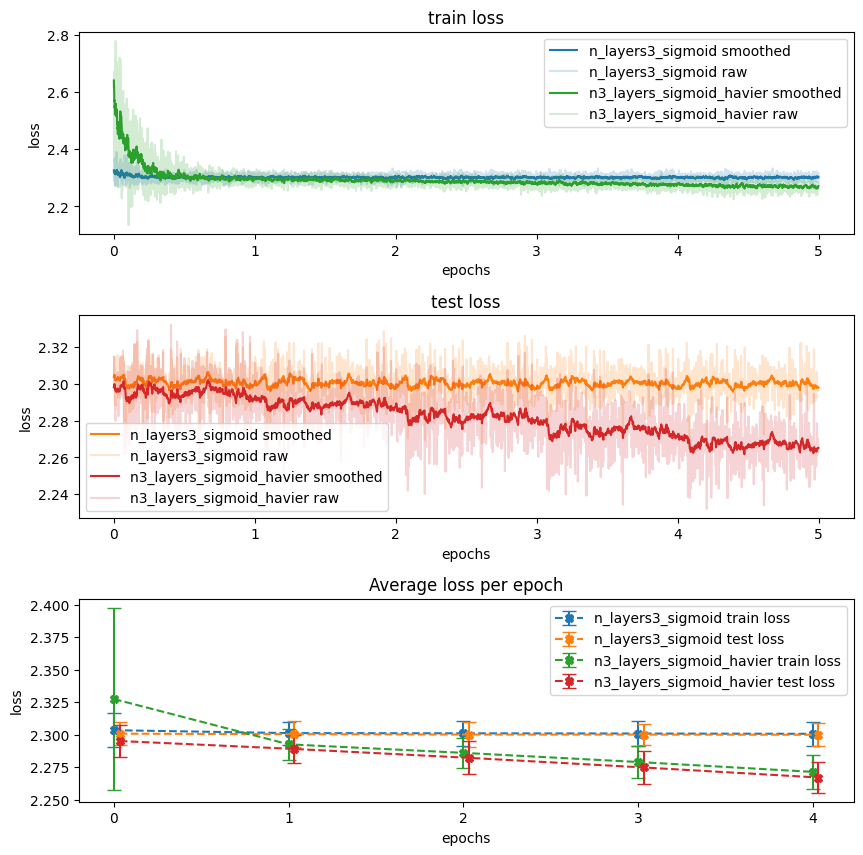

In [ ]:
history_plotter.plot(["n_layers3_sigmoid", model_name])

Видим, что нейросеть стала хоть как-то учиться.

# Слои нормализации

## Internal covariate shift

Как мы увидели, инициализация весов помогает сохранить дисперсию на выходе из слоя. Однако после выполнения обратного распространения ошибки веса в слое изменяются, и у нас пропадает гарантия сохранения распределений.

В [статье про Batch Normalization 🎓[arxiv]](https://arxiv.org/pdf/1502.03167.pdf) авторы предложили решение этой проблемы, назвав его **internal covariate shift**.

**Internal covariate shift** — это изменение распределения выхода слоя активации из-за изменения обучаемых параметров во время обучения.



<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/internal_covariate_shift_example.png" width="1000">

Пусть у нас $k$-ый нейрон $i$-го слоя переводит выход $i$−1 слоя с распределением <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в новое пространство с распределением <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>.

При обучении:
- нейросеть делает предсказание,
- считается значение функции потерь,
- делается обратное распространение ошибки,
- обновляются веса.


После обновления весов $k$-ый нейрон $i$-го слоя будет переводить выходы $i$−1 слоя <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в пространство с другим распределением <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

При этом $i$+1 слой учился работать со старым распределением  <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>, и будет хуже обрабатывать <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

### Плохой вариант борьбы с этим

Можно на каждом слое нормировать **каждый признак** (выход каждого нейрона), используя среднее и дисперсию по батчу:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$




Проблема в том, что таким образом мы можем попасть в область линейной составляющей нашей функции. Например, в случае сигмоиды:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/domain_of_linear_of_sigmoid_function.png" width="500"></center>

Получаем набор линейных слоев фактически без функций активации, следовательно, все вырождается в однослойную сеть. Не то, что нам надо.

## Batch Normalization

 <center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization.png" width="400"> </center>

Надо дать нейронной сети **возможность перемещать распределение выходов** слоя из области $0$ и самой **подбирать дисперсию**. Для этой цели используется **батч-нормализация** (*batch normalization*), которая вводит в нейронную сеть дополнительную операцию между соседними скрытыми слоями.

Она состоит из **нормализации** входящих (в слой батч-нормализации) значений, полученных от скрытого слоя, **масштабирования** и **сдвига** с применением двух новых параметров и передачи полученных значений на вход следующему скрытому слою.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batch_normalization_compute_moving_average.png" width="1000"></center>

Параметры, используемые в батч-нормализации ($\gamma$ — параметр, отвечающий за **сжатие**, и $\beta$ — параметр, отвечающий за **сдвиг**), являются **обучаемыми параметрами** (наподобие весов и смещений скрытых слоев).

Помимо обучаемых параметров $\gamma$ и $\beta$ в слое батч-нормализации существуют также необучаемые параметры: **скользящее среднее матожидания** (_Mean Moving Average_) и **скользящее среднее дисперсий** (_Variance Moving Average_), служащие для сохранения состояния слоя батч-нормализации.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_layer_parameters.png" width="900"></center>

Параметры $\gamma$, $\beta$, а также оба скользящих средних вычисляются для каждого слоя батч-нормализации отдельно и являются векторами с **длиной, равной количеству входящих признаков.**

В процессе обучения мы подаем в нейронную сеть **по одному мини-батчу за раз**. Процедуру обработки значений одного признака $x^{(k)}$ (фиолетовая колонка на изображении ниже), который для краткости мы будем обозначать $x$,  из одного мини-батча $ B = \{x_{1},\ldots, x_{m}\} $ можно представить следующим образом:



Шаг **масштабирования** Gamma ($γ$) и шаг **сдвига** Beta ($β$) являются главным новшеством батч-нормализации, поскольку, в отличие от предыдущего рассмотренного примера, нормированные значения больше не обязаны иметь среднее, равное $0$, и единичную дисперсию. Батч-нормализация позволяет сдвигать среднее нормированных значений и масштабировать дисперсию. Фактически теперь **нейросеть даже может отменить нормализацию входных данных, если считает ее ненужной.**

Для наглядности проиллюстрируем размерности промежуточных переменных на следующем изображении:

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batch_normalization_compute_moving_average_scheme.png" width="1000">

После прямого прохода параметры $\gamma$ и $\beta$ **обновляются через обратное распространение ошибки** так же, как и веса скрытых слоев.

### Скользящее среднее

Выше мы обсуждали то, что в процессе обучения слой **батч-нормализации** рассчитывает значение **среднего и дисперсии** каждого признака в соответствующем **мини-батче**. Предположим, что нам нужно сделать предсказание на **одном объекте**. Во время предсказания батч у нас уже отсутствует. Откуда брать среднее и дисперсию?

Во время предсказания используется **скользящее среднее**, которое было **рассчитано и сохранено в процессе обучения**.

$$\large \mu_{mov_{B}} = (1-\alpha)\mu_{mov_{B-1}}+\alpha\mu_{B} $$

$$\large \sigma_{mov_{B}} = (1-\alpha)\sigma_{mov_{B-1}}+\alpha\sigma_{B} $$

Обычно используется параметр $\alpha = 0.1$

Для перевода модели из режима обучения в режим тестирования и обратно в PyTorch используются `model.train()` и `model.eval()`.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Батч-нормализация использует статистику по батчу}}&\large{\text{Батч-нормализация использует скользящие средние}}\\
\large{\text{Cкользящие средние копятся}}
\end{array}
$$



Почему используется именно **скользящее среднее**, а **не статистика всей обучающей выборки**?

При таком подходе нам бы пришлось хранить **средние всех признаков** для **всех батчей**, пропущенных через нейросеть в ходе обучения. Это ужасно невыгодно по памяти. Вместо этого **скользящее среднее** выступает в качестве приближенной оценки **среднего и дисперсии** обучающего набора. В этом случае эффективность использования ресурсов увеличивается: нам нужно **хранить в памяти только одно число** — значение скользящего среднего, полученное на последнем шаге.

Проиллюстрировать преимущество использования скользящего среднего можно на следующем примере:

Предположим, что у нас есть массив объектов, обладающих некоторым признаком $x$ (обучающая выборка), и некоторый черный ящик, извлекающий по $k$ объектов из этого массива (Data loader). Наша задача — дать оценку ожидаемому среднему этих $k$ объектов. В данном примере для простоты будем извлекать $k$ объектов из некоего распределения случайным образом.

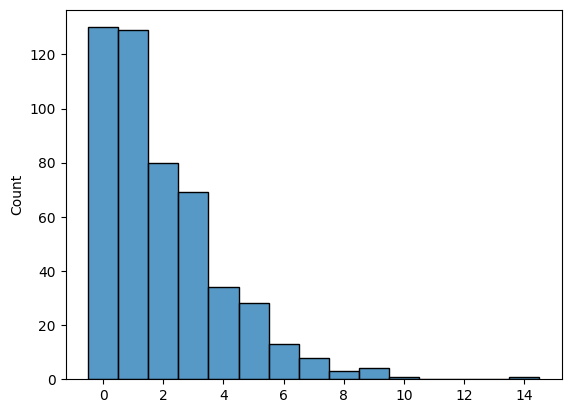

means score: 1.99956800, [80112 bytes]
ema sccore: 1.97321201, [32 bytes]


In [ ]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sample = np.random.negative_binomial(2, 0.5, 500)
sns.histplot(data=sample, discrete=True)
plt.show()

ema = 0
alpha = 0.01
means = np.array([])

for i in range(10000):
    sample = np.random.negative_binomial(2, 0.5, 50)
    ema = (1 - alpha) * ema + alpha * sample.mean()
    means = np.append(means, sample.mean())

print(f"means score: {means.mean():.8f}, [{sys.getsizeof(means)} bytes]")
print(f"ema sccore: {ema:.8f}, [{sys.getsizeof(ema)} bytes]")

Видно, что мы получили довольно точную оценку, использовав скользящее среднее.

### Batch Normalization как регуляризация

Почему для нейросети с батч-нормализацией можно использовать более высокие learning rate?

Оказывается, **батч-нормализация** делает **неявную регуляризацию на веса**.



Вспомним формулы:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$

$$ \text{BN}_{\gamma, \beta}(x_{i}) = \gamma \hat{x}_{i} + \beta $$

Так как мы шкалируем, то домножение весов $W$ на константу $a$ не меняет выходные значения слоя:

$$BN((aW)u) = BN(Wu)$$

Градиент слоя по входу не меняется:

$$\dfrac {\partial BN((aW)u)} {\partial u} = \dfrac {\partial BN(Wu)} {\partial u}$$

А **градиент по весам уменьшается** в $a$ раз:

$$\dfrac {\partial BN((aW)u)} {\partial aW} = \dfrac 1 a \dfrac {\partial BN(Wu)} {\partial W} $$

Таким образом, нейросеть автоматически не дает большим весам расти.

### Сглаживающий эффект Batch Normalization

**Batch Normalization** была разработана на идее необходимости коррекции **Internal covariate shift**. В 2019 году вышла [статья 🎓[arxiv]](https://arxiv.org/pdf/1805.11604.pdf), которая показала, что влияние коррекции **Internal covariate shift** на качество обучения не так велико, как считали авторы **Batch Normalization**.

Другим интересным эффектом Batch Normalization оказалось **сглаживание ландшафта** функции потерь. Batch Normalization улучшает гладкость пространства решений и облегчает поиск в нем минимума. Именно благодаря сглаживанию ландшафта Batch Normalization справляется с затуханием и взрывом градиента.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_helps_find_minimum_of_function.jpg" width="900"></center>

### Используем Batch Normalization в PyTorch

Так как наша модель из-за **Batch Normalization** ведет себя по-разному во время **обучения** и во время **тестирования**, мы должны прямо ей сообщать, обучается она сейчас или нет. Делается это при помощи функций `model.train` и `model.eval`

```python
# Pseudocode for training a model in pure pytorch
def train(model, optimizer, criterion, train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        for train_batch in train_loader:
            do_train_step(model, train_batch, optimizer, criterion)
        
        model.eval()
        for val_batch in val_loader:
            do_test_step(model, val_batch, optimizer, criterion)
        
```

При использовании для обучения PyTorch Lightning **гарантируется**, что связанный с обучением `training_step()` будет выполнен для модели в состоянии `model.train()` и что связанный с запуском модели на тестовой выборке `validation_step()` будет выполнен для модели в состоянии `model.eval()`. **Это позволяет нам упростить код и не допустить ошибку**.

In [ ]:
class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
model_name = "batchnorm2"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

In [ ]:
trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


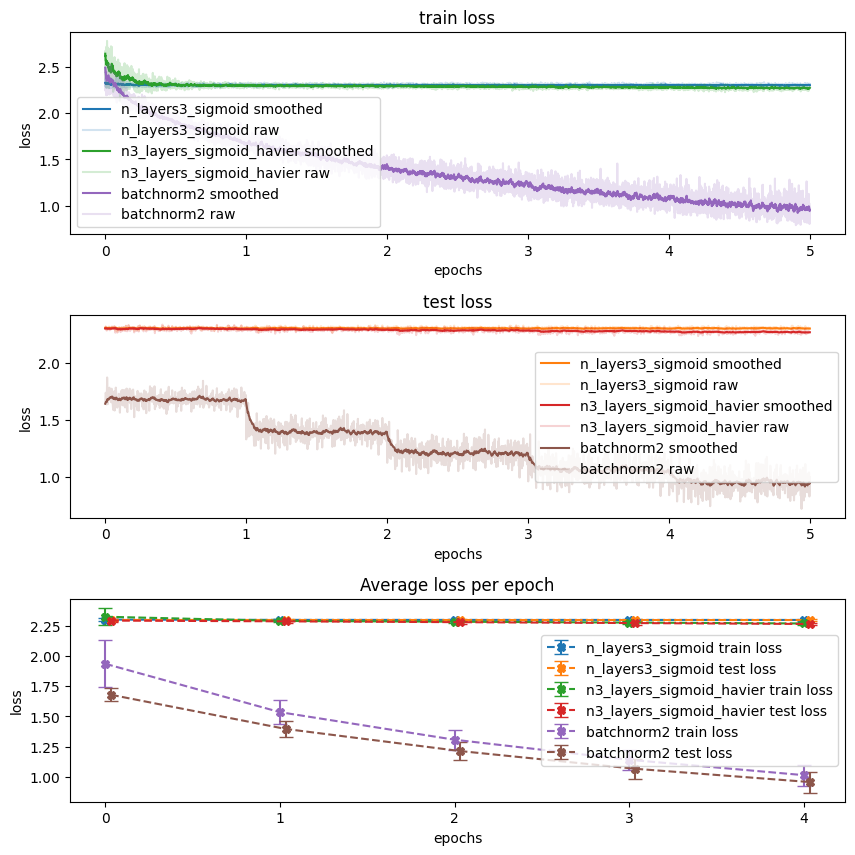

In [ ]:
history_plotter.add(history)
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

Попробуем, согласно советам, увеличить learning rate:

In [ ]:
model_name = "batchnorm_increased_lr"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


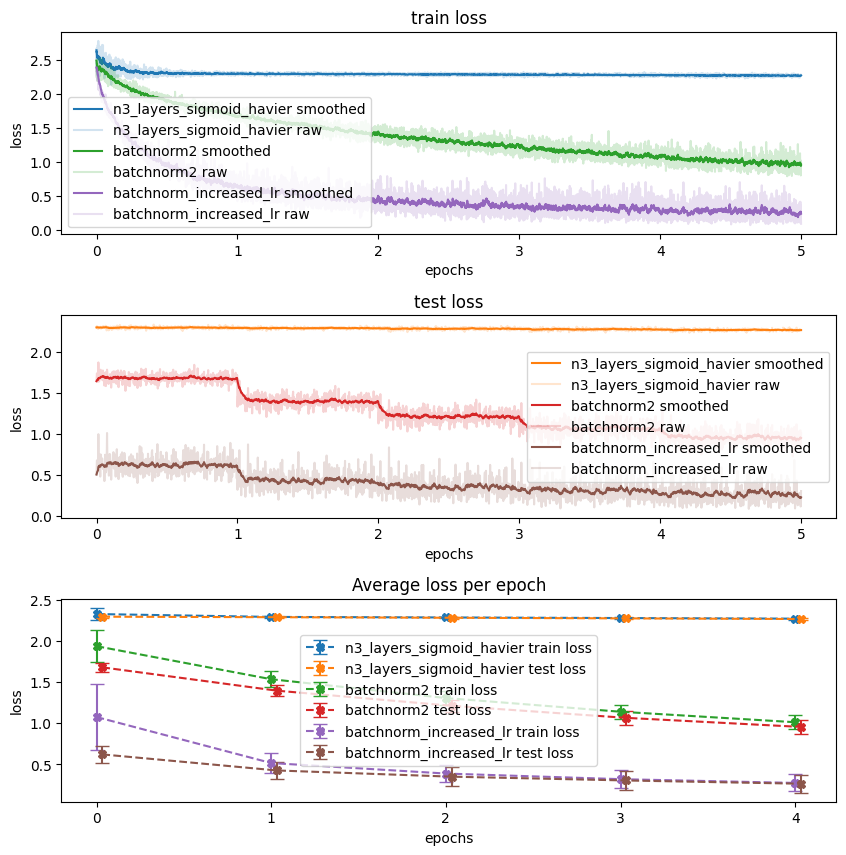

In [ ]:
history_plotter.plot(["n3_layers_sigmoid_havier", "batchnorm2", model_name])

### Советы по использованию Batch Normalization

Стоит помнить, что с батч-нормализацией:

* Чем **меньше размер батча в обучении**, тем **хуже** будет работать Batch Normalization.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnorm_batch_size.png" width="500"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1803.08494.pdf">Group Normalization</a></em></center>





* В слое, после которого поставили Batch Normalization, можно **убрать bias** (параметр $\beta$ в Batch Normalization берет эту роль на себя).

* Другое расписание **learning rate: большее значение** в начале обучения и быстрое уменьшение в процессе обучения.

* Важно перемешивать объекты (составлять новые батчи) между эпохами. Единицей обучения параметров $\beta$ и $\gamma$ являются батчи. Если их не перемешивать, то из 6400 объектов в тренировочном датасете получим лишь 100 объектов (при условии, что в батче 64 объекта) для обучения $\beta$ и $\gamma$. Данное требование учитывается автоматически при обучении нейронных сетей.

* Слой Batch Normalization рекомендуется ставить после сверточных слоев.

#### Ставить Batch Normalization до или после активации?



##### До

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_before_activation.png" width="350"></center>

* **Рекомендуется авторами статьи, где предложили Batch Normalization**.
* Во многих сверточных архитектурах, например, [**ResNet** 🎓[arxiv]](https://arxiv.org/pdf/1512.03385.pdf) и [**MobileNetV2** 🎓[arxiv]](https://arxiv.org/pdf/1801.04381.pdf), Batch Normalization ставится именно так.


##### После

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/batchnormalization_after_activation.png" width="350"></center>

* Для популярной **ReLU BN**, поставленная до активации, может приводить в определённых случаях к “умирающей **ReLU**”, когда большая часть ее входов меньше $0$, и поэтому через них градиент не проходит.



<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/batchnormalization_before_or_after_relu.png" width="500">

<em>Source: <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">BN experiments</a></em></center>

**Вывод:** В общем случае рекомендуется размещать слой Batch Normalization перед активацией.

*Экспериментировать с этой последовательностью следует в последнюю очередь.*